In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### 2.1 Exploration

Binary dataset, 564 of class 1 and 282 of class 2, together 846

([<matplotlib.axis.XTick at 0x7fdbaa1ec9a0>,
 [Text(0, 0, 'Class 1'), Text(1, 0, 'Class 2')])

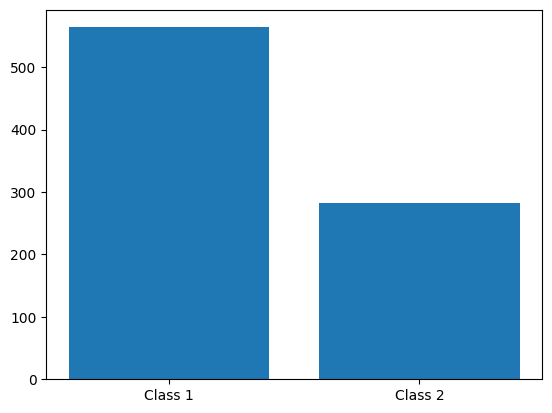

In [72]:
df = pd.read_csv("train.csv")
df.sample()
df.loc[:, "V1":"V3"]
classes = df.loc[:, "Class"].value_counts()
#print(classes, sum(classes))
y_pos = np.arange(len(classes), step=1)
plt.bar(y_pos, classes)
plt.xticks(y_pos, {"Class 1", "Class 2"})

#print(len(np.array(classes) == 2))
#print(len(classes))
#df.columns
#print(df.head)
#print(df.mean)
#print(df.median)

In [73]:
df.describe()
df.fillna(0)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V33,V34,V35,V36,V37,V38,V39,V40,V41,Class
count,846.000000,846.000000,846.000000,821.000000,846.000000,846.000000,846.000000,846.000000,846.000000,846.000000,...,846.000000,846.000000,846.000000,846.000000,821.000000,846.000000,846.000000,846.000000,846.000000,846.000000
mean,4.790476,3.054551,0.739953,0.030451,0.946809,0.277778,1.669031,37.422813,1.342790,1.784870,...,0.903073,1.241135,0.926714,3.922100,2.549406,0.671395,8.643191,0.059102,0.706856,1.333333
std,0.531991,0.813983,1.504545,0.198281,2.318081,1.045544,2.220221,9.030008,2.018433,1.773856,...,1.526124,2.248684,1.239133,0.992636,0.625021,1.093633,1.223700,0.342364,2.145396,0.471683
min,2.000000,0.803900,0.000000,0.000000,0.000000,0.000000,0.000000,9.100000,0.000000,0.000000,...,0.000000,0.000000,0.000000,2.279000,1.467000,0.000000,4.948000,0.000000,0.000000,1.000000
25%,4.499000,2.510175,0.000000,0.000000,0.000000,0.000000,0.000000,30.800000,0.000000,0.000000,...,0.000000,0.000000,0.000000,3.497000,2.101000,0.000000,8.009500,0.000000,0.000000,1.000000
50%,4.840000,3.052400,0.000000,0.000000,0.000000,0.000000,1.000000,37.850000,1.000000,1.500000,...,0.000000,0.000000,1.000000,3.732500,2.461000,0.000000,8.508000,0.000000,0.000000,1.000000
75%,5.119000,3.415725,1.000000,0.000000,1.000000,0.000000,3.000000,43.800000,2.000000,3.000000,...,1.000000,2.000000,1.000000,3.980000,2.861000,1.000000,9.019750,0.000000,0.000000,2.000000
max,6.496000,7.918400,12.000000,2.000000,36.000000,13.000000,18.000000,60.700000,24.000000,12.000000,...,12.000000,18.000000,7.000000,10.695000,5.750000,8.000000,14.700000,4.000000,27.000000,2.000000
